In [1]:
setwd(paste0(Sys.getenv('ROOT'), '/R'))
getwd()

[1] "/mnt/hdd/develop/kaggle/house-prices/R/R"

In [173]:
source('main.R')

data <- kaggle.house$loadData()

df.combined <- 
    kaggle.house$getCombinedDataset(data$train, data$test) %>%
    rename(price = SalePrice) %>%
    mutate(
        log.price = log(price),
        sq.feat.price = price / GrLivArea
    )  

trainset <- 
    df.combined %>% 
    filter(dataSource == "train") %>%
    select(-dataSource)

trainset %>% nrow

[1] 1460

In [167]:
trainset.cat <- trainset %>% 
    select(one_of(union(kaggle.house$getCategoricalColumnNames(.), 
                        c("price", "log.price", "sq.feat.price"))))

trainset.num <-  trainset %>% select_if(is.numeric)

trainset.cat %>% colnames
trainset.num %>% colnames

[1] "Alley"         "BldgType"      "BsmtCond"      "BsmtExposure" 
 [5] "BsmtFinType1"  "BsmtFinType2"  "BsmtQual"      "CentralAir"   
 [9] "Condition1"    "Condition2"    "Electrical"    "ExterCond"    
[13] "Exterior1st"   "Exterior2nd"   "ExterQual"     "Fence"        
[17] "FireplaceQu"   "Foundation"    "Functional"    "GarageCond"   
[21] "GarageFinish"  "GarageQual"    "GarageType"    "Heating"      
[25] "HeatingQC"     "HouseStyle"    "KitchenQual"   "LandContour"  
[29] "LandSlope"     "LotConfig"     "LotShape"      "MasVnrType"   
[33] "MiscFeature"   "MSSubClass"    "MSZoning"      "Neighborhood" 
[37] "PavedDrive"    "PoolQC"        "RoofMatl"      "RoofStyle"    
[41] "SaleCondition" "SaleType"      "Street"        "Utilities"    
[45] "price"         "log.price"     "sq.feat.price"

[1] "LotFrontage"   "LotArea"       "OverallQual"   "OverallCond"  
 [5] "YearBuilt"     "YearRemodAdd"  "MasVnrArea"    "BsmtFinSF1"   
 [9] "BsmtFinSF2"    "BsmtUnfSF"     "TotalBsmtSF"   "X1stFlrSF"    
[13] "X2ndFlrSF"     "LowQualFinSF"  "GrLivArea"     "BsmtFullBath" 
[17] "BsmtHalfBath"  "FullBath"      "HalfBath"      "BedroomAbvGr" 
[21] "KitchenAbvGr"  "TotRmsAbvGrd"  "Fireplaces"    "GarageYrBlt"  
[25] "GarageCars"    "GarageArea"    "WoodDeckSF"    "OpenPorchSF"  
[29] "EnclosedPorch" "X3SsnPorch"    "ScreenPorch"   "PoolArea"     
[33] "MiscVal"       "MoSold"        "YrSold"        "price"        
[37] "log.price"     "sq.feat.price"

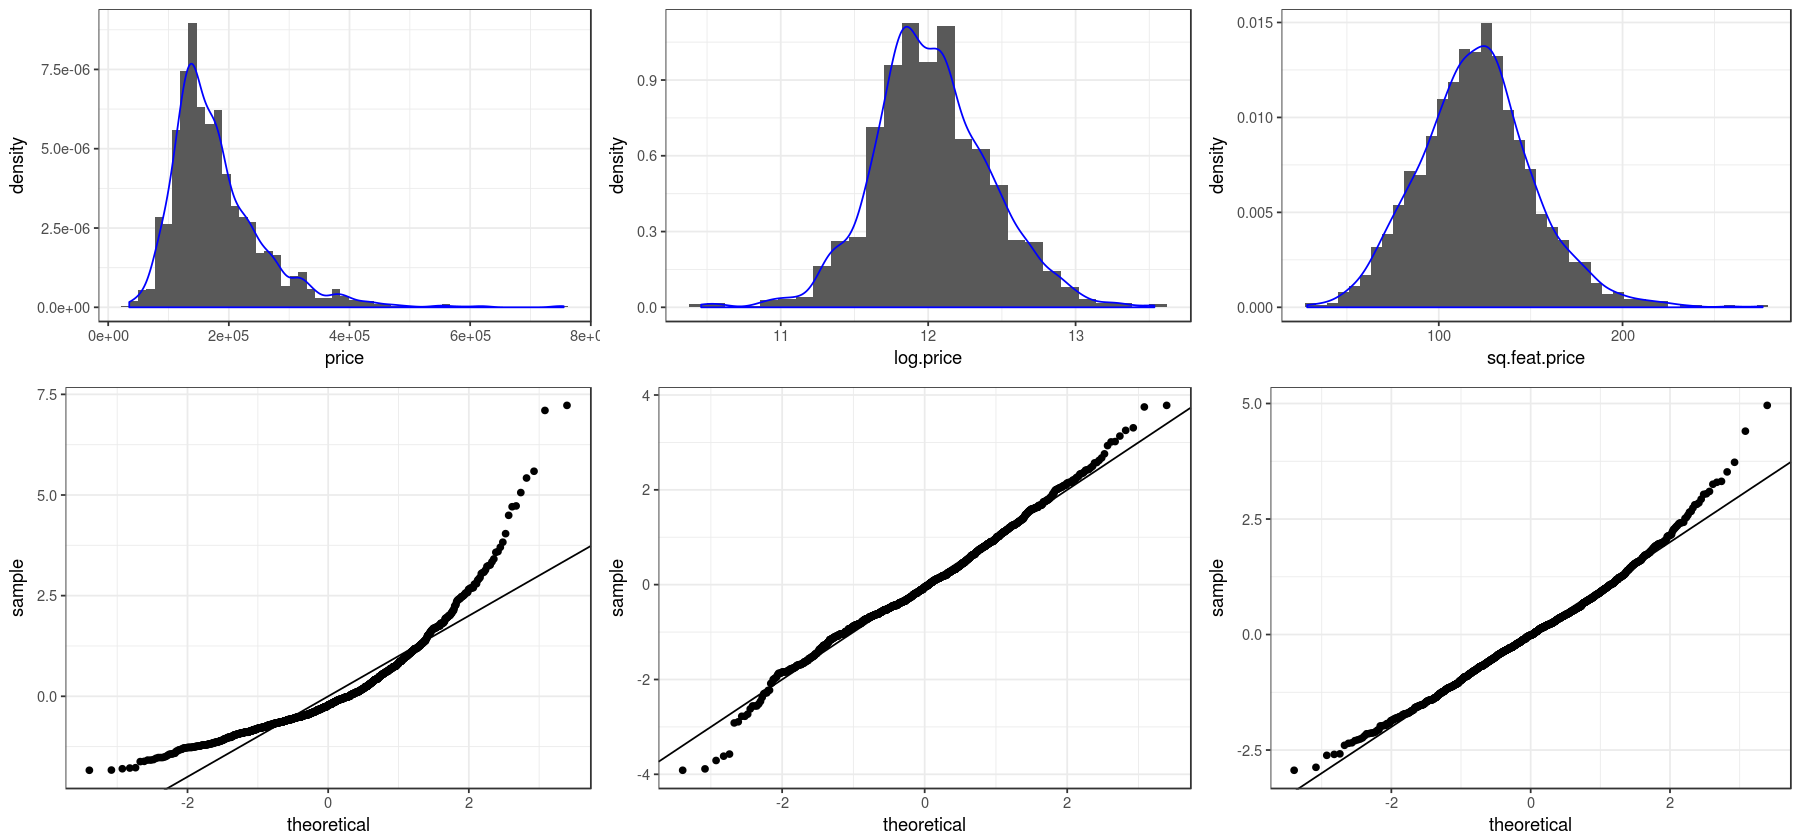

In [198]:
p1 <- trainset %>% 
    ggplot(aes(price)) +
    geom_histogram(aes(y=..density..), binwidth=14e3) +
    geom_density(color="blue") +
    theme_bw()

p2 <- trainset %>% 
    ggplot(aes(log.price)) +
    geom_histogram(aes(y=..density..), binwidth=0.12) +
    geom_density(color="blue") +
    theme_bw()

p3 <- trainset %>% 
    ggplot(aes(sq.feat.price)) +
    geom_histogram(aes(y=..density..), binwidth=6) +
    geom_density(color="blue") +
    theme_bw()

qq1 <- trainset %>% 
    mutate(price.norm = (price - mean(price)) / sd(price)) %>%
    ggplot() +
    geom_qq(aes(sample=price.norm)) +
    geom_abline(slope=1) +
    theme_bw()

qq2 <- trainset %>% 
    mutate(
        log.price.norm = (log.price - mean(log.price)) / sd(log.price)
    ) %>%
    ggplot() +
    geom_qq(aes(sample=log.price.norm)) +
    geom_abline(slope=1) +
    theme_bw()

qq3 <- trainset %>% 
    mutate(
        sq.feat.price.norm = (sq.feat.price - mean(sq.feat.price)) / sd(sq.feat.price)
    ) %>%
    ggplot() +
    geom_qq(aes(sample=sq.feat.price.norm)) +
    geom_abline(slope=1) +
    theme_bw()

options(repr.plot.width = 15, repr.plot.height = 7)

x <- grid.arrange(p1, p2, p3, qq1, qq2, qq3, 
                  layout_matrix=rbind(c(1, 2, 3), 
                                      c(4, 5, 6)),
                 heights=c(45, 55))

In [206]:
log.price.vs.cat <- 
    trainset.cat %>%
    gather(var.name, var.value, -price, -log.price, -sq.feat.price) %>%
    group_by(var.name) %>%
    nest %>% 
    mutate(
        mod = map(data, ~lm(price ~ var.value, .)),
        glance = map(mod, broom::glance),
        r2 = map_dbl(glance, 'r.squared'),
        
        mod.log = map(data, ~lm(log.price ~ var.value, .)),
        glance.log = map(mod.log, broom::glance),
        r2.log = map_dbl(glance.log, 'r.squared'),
        
        mod.sq.feat = map(data, ~lm(sq.feat.price ~ var.value, .)),
        glance.sq.feat = map(mod.sq.feat, broom::glance),
        r2.sq.feat = map_dbl(glance.sq.feat, 'r.squared')
    ) %>%
    select(var.name, r2, r2.log, r2.sq.feat) 

log.price.vs.cat %>% arrange(desc(r2)) %>% head(10) %>% t
log.price.vs.cat %>% arrange(desc(r2.log)) %>% head(10) %>% t
log.price.vs.cat %>% arrange(desc(r2.sq.feat)) %>% head(10) %>% t

var.name,Neighborhood,ExterQual,KitchenQual,BsmtQual,PoolQC,Alley,GarageFinish,Foundation,MSSubClass,GarageType
r2,0.5455750,0.4773878,0.4565986,0.4537561,0.4486514,0.2854967,0.2672764,0.2563684,0.2463160,0.2066384
r2.log,0.5708078,0.4611220,0.4476397,0.4353770,0.4602011,0.2328075,0.3234522,0.3036511,0.3301271,0.2692201
r2.sq.feat,0.38791391,0.23707572,0.23414862,0.26956231,0.03188035,0.19737971,0.14810895,0.19717379,0.36358051,0.12318764


var.name,Neighborhood,ExterQual,PoolQC,KitchenQual,BsmtQual,MSSubClass,GarageFinish,Foundation,GarageType,HeatingQC
r2,0.5455750,0.4773878,0.4486514,0.4565986,0.4537561,0.2463160,0.2672764,0.2563684,0.2066384,0.1955005
r2.log,0.5708078,0.4611220,0.4602011,0.4476397,0.4353770,0.3301271,0.3234522,0.3036511,0.2692201,0.2335174
r2.sq.feat,0.38791391,0.23707572,0.03188035,0.23414862,0.26956231,0.36358051,0.14810895,0.19717379,0.12318764,0.13564815


var.name,Neighborhood,MSSubClass,BsmtQual,ExterQual,HouseStyle,KitchenQual,BsmtFinType1,Alley,Foundation,BsmtExposure
r2,0.54557499,0.24631597,0.45375607,0.47738778,0.08631263,0.45659862,0.19259760,0.28549673,0.25636840,0.13041556
r2.log,0.5708078,0.3301271,0.4353770,0.4611220,0.1020965,0.4476397,0.1982448,0.2328075,0.3036511,0.1101804
r2.sq.feat,0.3879139,0.3635805,0.2695623,0.2370757,0.2342016,0.2341486,0.2109576,0.1973797,0.1971738,0.1575012


In [207]:
log.price.vs.num <- 
    trainset.num %>%
    gather(var.name, var.value, -price, -log.price, -sq.feat.price) %>%
    group_by(var.name) %>%
    nest %>% 
    mutate(
        mod = map(data, ~lm(price ~ var.value, .)),
        glance = map(mod, broom::glance),
        r2 = map_dbl(glance, 'r.squared'),
        
        mod.log = map(data, ~lm(log.price ~ var.value, .)),
        glance.log = map(mod.log, broom::glance),
        r2.log = map_dbl(glance.log, 'r.squared'),
        
        mod.sq.feat = map(data, ~lm(sq.feat.price ~ var.value, .)),
        glance.sq.feat = map(mod.sq.feat, broom::glance),
        r2.sq.feat = map_dbl(glance.sq.feat, 'r.squared')
    ) %>%
    select(var.name, r2, r2.log, r2.sq.feat)

log.price.vs.num %>% arrange(desc(r2)) %>% head(10) %>% t
log.price.vs.num %>% arrange(desc(r2.log)) %>% head(10) %>% t
log.price.vs.num %>% arrange(desc(r2.sq.feat)) %>% head(10) %>% t

var.name,OverallQual,GrLivArea,GarageCars,GarageArea,TotalBsmtSF,X1stFlrSF,FullBath,TotRmsAbvGrd,YearBuilt,YearRemodAdd
r2,0.6256519,0.5021487,0.4101239,0.3886668,0.3764811,0.3670569,0.3143439,0.2848604,0.2734216,0.2571514
r2.log,0.6677904,0.4912982,0.4632501,0.4236546,0.3747080,0.3563864,0.3537520,0.2856071,0.3440646,0.3199122
r2.sq.feat,0.224460088,0.011958585,0.161564585,0.155558976,0.175052026,0.069944404,0.007727541,0.034941982,0.307937868,0.201202416


var.name,OverallQual,GrLivArea,GarageCars,GarageArea,TotalBsmtSF,X1stFlrSF,FullBath,YearBuilt,YearRemodAdd,GarageYrBlt
r2,0.6256519,0.5021487,0.4101239,0.3886668,0.3764811,0.3670569,0.3143439,0.2734216,0.2571514,0.2365477
r2.log,0.6677904,0.4912982,0.4632501,0.4236546,0.3747080,0.3563864,0.3537520,0.3440646,0.3199122,0.2927598
r2.sq.feat,0.224460088,0.011958585,0.161564585,0.155558976,0.175052026,0.069944404,0.007727541,0.307937868,0.201202416,0.220505860


var.name,YearBuilt,OverallQual,GarageYrBlt,YearRemodAdd,TotalBsmtSF,GarageCars,GarageArea,BsmtFinSF1,BedroomAbvGr,X2ndFlrSF
r2,0.27342162,0.62565189,0.23654768,0.25715139,0.37648109,0.41012394,0.38866676,0.14932027,0.02829567,0.10197408
r2.log,0.34406465,0.66779037,0.29275984,0.31991222,0.37470800,0.46325013,0.42365461,0.13840117,0.04369926,0.10195248
r2.sq.feat,0.3079379,0.2244601,0.2205059,0.2012024,0.1750520,0.1615646,0.1555590,0.1543331,0.1267147,0.1211989


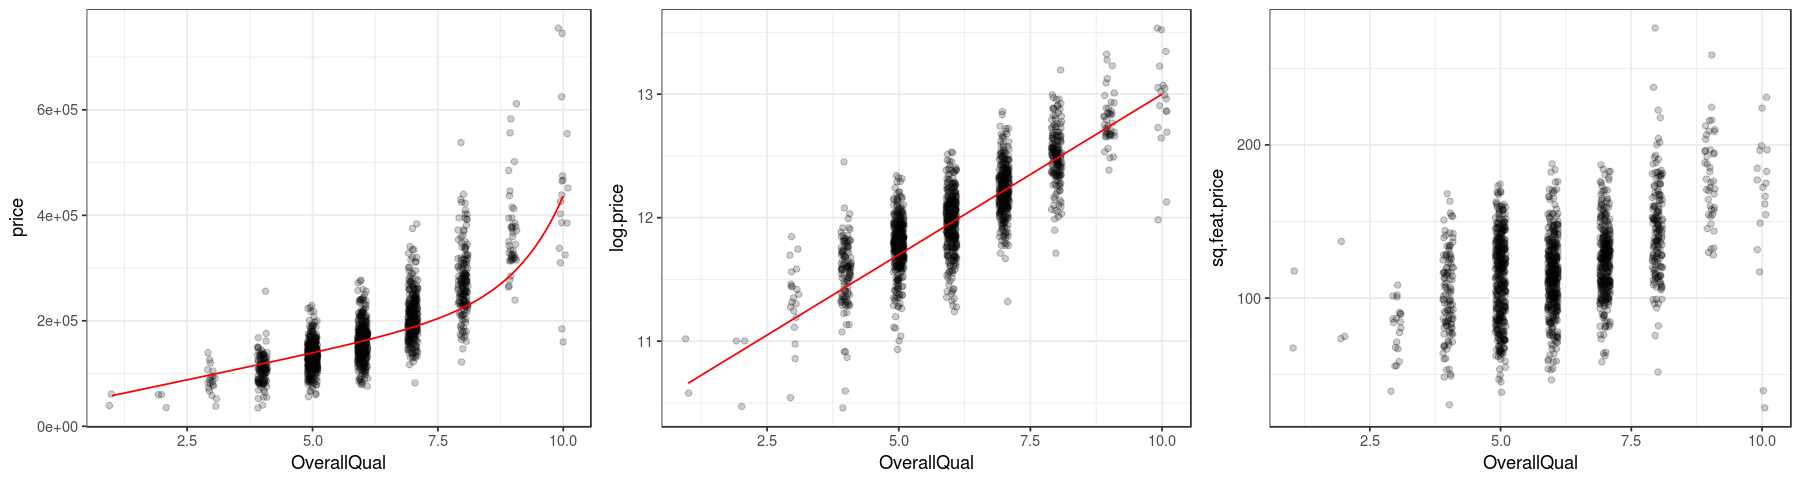

In [208]:
p1 <- 
    trainset %>%
    ggplot() +
    geom_jitter(aes(x=OverallQual, y=price), alpha=0.2, width=0.1, height=0) +
    stat_function(fun = function (x) { 2e4*x + exp(x + 2.2) + 3.8e4 }, colour = "red") +
    theme_bw()

p2 <- 
    trainset %>%
    ggplot() +
    geom_jitter(aes(x=OverallQual, y=log.price), alpha=0.2, width=0.1, height=0) +
    stat_function(fun = function (x) { 0.26*x + 10.4 }, colour = "red") +
    theme_bw()

p3 <-
    trainset %>%
    ggplot() +
    geom_jitter(aes(x=OverallQual, y=sq.feat.price), alpha=0.2, width=0.1, height=0) +
    theme_bw()

options(repr.plot.width = 15, repr.plot.height = 4)

grid.arrange(p1, p2, p3, layout_matrix=rbind(c(1, 2, 3)))

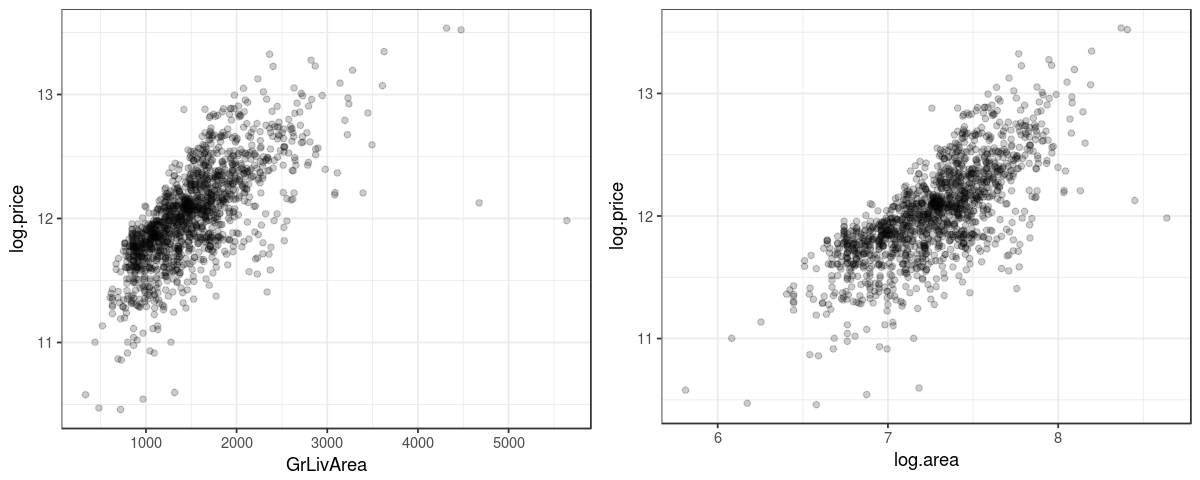

In [154]:
p1 <- 
    trainset %>%
    ggplot() +
    geom_point(aes(x=GrLivArea, y=log.price), alpha=0.2) +
    theme_bw()

p2 <- 
    trainset %>%
    mutate(log.area = log(GrLivArea)) %>%
    ggplot() +
    geom_point(aes(x=log.area, y=log.price), alpha=0.2) +
    theme_bw()

options(repr.plot.width = 10, repr.plot.height = 4)
grid.arrange(p1, p2,layout_matrix=rbind(c(1, 2)))

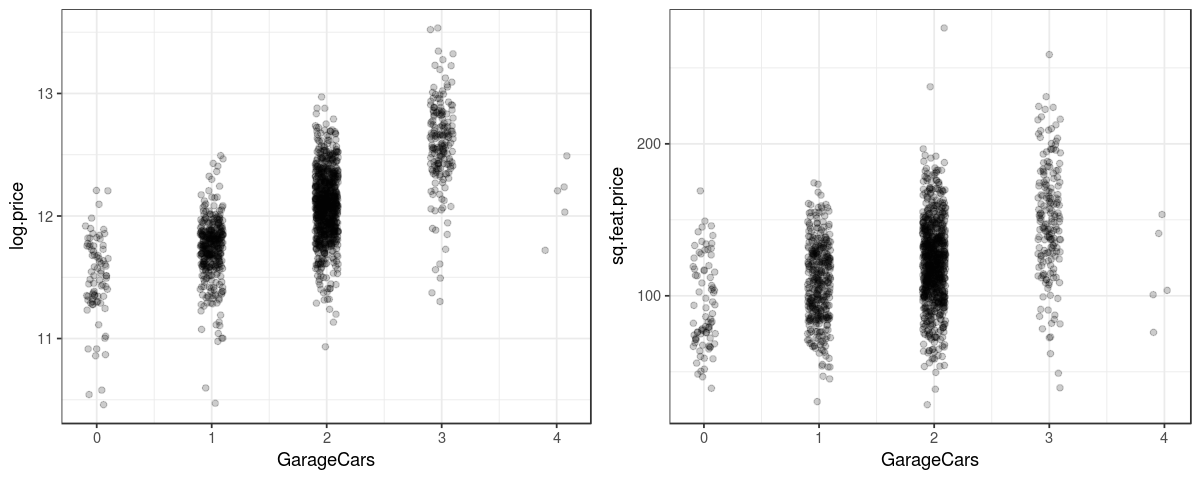

In [155]:
p1 <-
    trainset %>%
    ggplot() +
    geom_jitter(aes(x=GarageCars, y=log.price), alpha=0.2, width=0.1, height=0) +
    theme_bw()

p2 <- 
    trainset %>%
    mutate(sq.feat.price = price / GrLivArea) %>%
    ggplot() +
    geom_jitter(aes(x=GarageCars, y=sq.feat.price), alpha=0.2, width=0.1, height=0) +
    theme_bw()

options(repr.plot.width = 10, repr.plot.height = 4)
grid.arrange(p1, p2, layout_matrix=rbind(c(1, 2)))

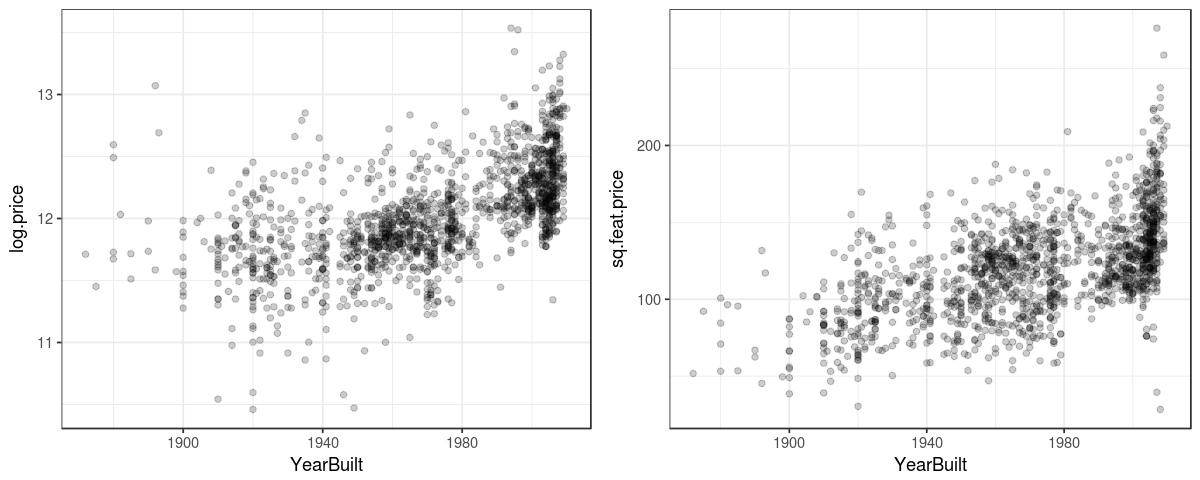

In [157]:
p1 <- 
    trainset %>%
    ggplot() +
    geom_point(aes(x=YearBuilt, y=log.price), alpha=0.2) +
    theme_bw()

p2 <-
    trainset %>%
    mutate(sq.feat.price = price / GrLivArea) %>%
    ggplot() +
    geom_point(aes(x=YearBuilt, y=sq.feat.price), alpha=0.2) +
    theme_bw()

options(repr.plot.width = 10, repr.plot.height = 4)
grid.arrange(p1, p2, layout_matrix=rbind(c(1, 2)))